In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Set PYTHONHASHSEED to prevent hash randomization
os.environ['PYTHONHASHSEED'] = '12345'

In [3]:
# import
# plotting inline
%matplotlib inline

# working directory
import sys
sys.path.append('../src')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta as beta_dist
from scipy.stats import norm as norm_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [4]:
pd.set_option('display.max_rows', 1000)
import sys
sys.setrecursionlimit(10000)

In [5]:
from onlinelogisticregression import ( 
    ThompsonSamplingPolicy,
    GreedyPolicy,
    UCBPolicy,
    RandomPolicy,
)

In [30]:
result_folder = "results_delay_100"
os.makedirs( f"../{result_folder}", exist_ok=True)
prob = .2


In [8]:
# pseudo things to load the data
n_dim = 1
n_data_point_per_round = 1
lambda_ = 1
alpha = 1
true_weights = np.random.uniform(-1, 1, n_dim + 1)
policy_params = {'lambda_': lambda_, 'alpha': alpha, 'n_dim': n_dim, 
                        'true_weights_full': true_weights,
                        'n_data_point_per_round': n_data_point_per_round}

ts_lr = ThompsonSamplingPolicy(**policy_params)
exploit_lr = GreedyPolicy(**policy_params)
ucb_lr = UCBPolicy(**policy_params)
random_lr = RandomPolicy(**policy_params)

dp_dict = {'ts_lr': ts_lr, 
        'exploit_lr': exploit_lr,
        'ucb_lr': ucb_lr,
        # 'random_lr': random_lr
        }

In [20]:
experiment_params_name = [
"nArms",    "nPerRound",  "nRounds",    "nFeatures",    "lambda",   "alpha",    "nSims",    "seed"
]
experiment_params_nums = [
    # [2,          100,         50,          1,              0.1,        10,          10,         66],
# [2,          100,         50,          2,              0.1,        1,          10,         66],
# [10,         100,         50,          2,              0.1,        1,          10,         66],
# [10,         100,         500,          3,              0.1,        1,          10,         66],
# [10,         100,         50,          3,              0.1,        10,         10,         66],
[10,         100,          50,          3,              0.1,        10,         10,         66],
[10,         100,          50,          3,              0.1,        10,         10,         66],

[2,          100,          50,          2,              0.1,        10,         10,        66],
[2,          100,          50,          2,              0.1,        10,         10,         66],
# [2,          100,         50,          2,              0.1,        10,         10,         66],
# [2,          100,         50,          2,              0.1,        10,         2,         66], # for debugging
# [2,          100,         50,          2,              0.1,        1,          10,         66],
# [2,          100,         50,          2,              0.1,        10,         10,         66],

# [2,          100,          50,          2,              0.1,        1,         10,        66],
# [2,          100,          50,          2,              0.1,        .25,         10,        66],
# [2,          100,          50,          2,              1,        1,         10,        66],
# [2,          100,          50,          2,              1,        .25,         10,        66],


]
experiment_params_df = pd.DataFrame(experiment_params_nums, columns=experiment_params_name)
experiment_params_df

,nArms,nPerRound,nRounds,nFeatures,lambda,alpha,nSims,seed
0,10,100,50,3,0.1,10,10,66
1,10,100,50,3,0.1,10,10,66
2,2,100,50,2,0.1,10,10,66
3,2,100,50,2,0.1,10,10,66


In [21]:
def round_simulation(n_data_point_per_round, n_providers, n_dim, dp_dict, simulation, round_idx, X_full, X):
    round_df = pd.DataFrame({'k': [], 'x': [], 'reward': [], 'regret': [],
                            'true_weights': [], 'sample_weights': [], 
                            'mean_weights': [], 'std_weights': [],
                            'round': [],
                            'simul_id': [],
                            'policy': []})
                # generate data    
    for key, online_lr in dp_dict.items():
        print(key)    
        scores = online_lr.calculate_score(X)
        best_arms = online_lr.get_best_arm(scores)
        best_arm_features = online_lr.get_best_arm_features(best_arms, X)
        rewards, _ = online_lr.get_reward(best_arm_features)
        # delay the reward
        rewards = online_lr.get_reward_with_delayed_feedback(rewards, prob = 0.2)
        regrets = online_lr.calculate_regret(X_full, best_arm_features)

        # log the data
        if key == 'ts_lr':
            W = list(online_lr.W)
        else:
            W = [online_lr.w]*n_data_point_per_round

        temp_df = pd.DataFrame({'k': best_arms, 'x': list(best_arm_features),
                                'reward': rewards, 'regret': regrets,
                                'true_weights': [online_lr.true_weights]*n_data_point_per_round,
                                'sample_weights': W,
                                'mean_weights': [online_lr.m]*n_data_point_per_round,
                                'std_weights': [online_lr.q]*n_data_point_per_round,
                                'round':[round_idx]*n_data_point_per_round}, 
                                index=[round_idx]*n_data_point_per_round)

        # fit th e model
        online_lr.fit(best_arm_features, rewards)

        # append to round_df
        temp_df = temp_df.assign(simul_id = simulation, policy=key)

        round_df = pd.concat([round_df, temp_df])
    return round_df   

In [ ]:
# # regret analysis
for param_index in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[param_index]
    print(f"Running simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    np.random.seed(seed)
    
    # do experiment
    experiment_df = pd.DataFrame()
    for simulation in range(n_sims):
        # instance of TS
        # we generate 1 more true weight to the starting n_dim to simulate the new feature
        true_weights = np.random.uniform(-1, 1, n_dim + 1)
        policy_params = {'lambda_': lambda_, 'alpha': alpha, 'n_dim': n_dim, 
                         'true_weights_full': true_weights,
                         'n_data_point_per_round': n_data_point_per_round}

        ts_lr = ThompsonSamplingPolicy(**policy_params)
        exploit_lr = GreedyPolicy(**policy_params)
        ucb_lr = UCBPolicy(**policy_params)
        random_lr = RandomPolicy(**policy_params)
        
        dp_dict = {'ts_lr': ts_lr, 
                'exploit_lr': exploit_lr,
                'ucb_lr': ucb_lr,
                # 'random_lr': random_lr
                }
        
        #Step 1: online training for the first n_rounds
        for i in range(n_rounds):
            X_full = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim + 1))
            X = X_full[:, :, :-1]
            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim, dp_dict, simulation, i, X_full, X)

            experiment_df = pd.concat([experiment_df, round_df])

        # Step 2:
        # start introducing new features
        for key, online_lr in dp_dict.items():
            online_lr.add_new_feature()

        # Step 3: continue to train for another n_rounds with the new feature
        for i in range(n_rounds, 2*n_rounds):
            X = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim + 1))

            round_df = round_simulation(n_data_point_per_round, n_providers, n_dim+1, dp_dict, simulation, i, X, X)

            experiment_df = pd.concat([experiment_df, round_df])



    
    # save experiment_df to a file with the experiment parameters in the file name
    experiment_df.to_csv(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.csv", index=True)
    # also save it to a pickle file
    experiment_df.to_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")




In [23]:
# analysis with the results
# load the results from pickle
n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[0]
print(f"Analyzing simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
experiment_df = pd.read_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
regret_mean = experiment_df.reset_index().groupby(['policy','round'])['regret'].mean()


Analyzing simulation with 10 arms, 100 data points per round, 50 rounds, 3 features, lambda 0.1, alpha 10, 10 simulations


In [24]:
def plot_regret(regret_df, n_sims, regret_type='instant'):
    # closing all past figures
    plt.close('all')

    # opening figure to plot regret
    plt.figure(figsize=(10, 3), dpi=150)

    # loop for each decision policy
    for policy in dp_dict.keys():
        
        if regret_type == 'instant':
            plt.plot(regret_df.loc[policy,:].values, label=policy, linewidth=1.5)
        elif regret_type == 'cumulative':
            plt.plot(np.cumsum(regret_df.loc[policy,:].values), label=policy, linewidth=1.5)
        else:
            raise ValueError('regret_type must be either instant or cumulative')
        
    # adding title
    plt.title('Comparison of {} regret for each method in {} simulation'.format(regret_type, n_sims), fontsize=10)

    # adding legend
    plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

    # showing plot
    plt.show()

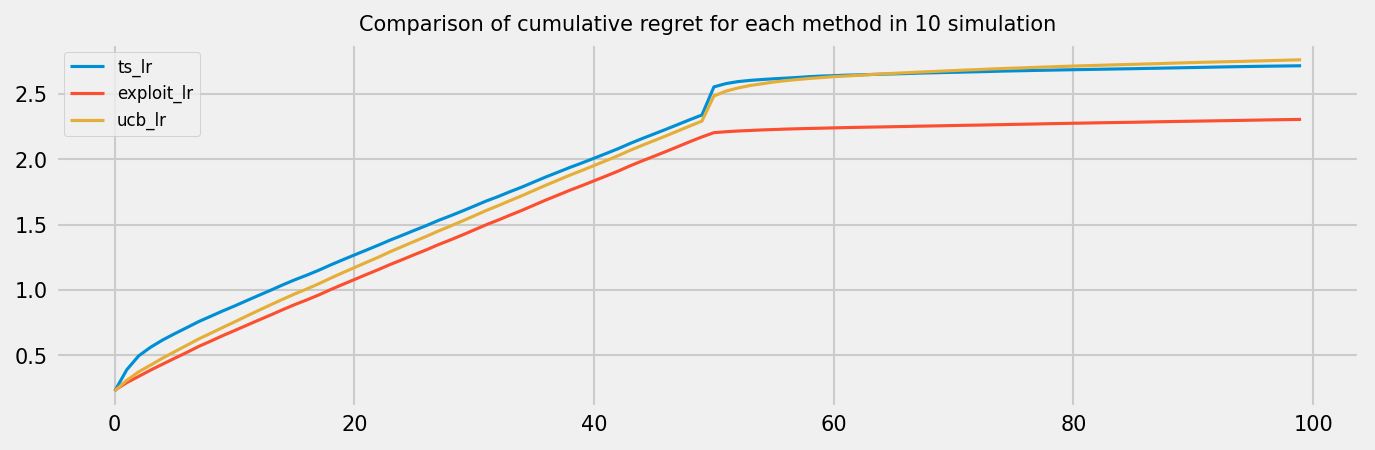

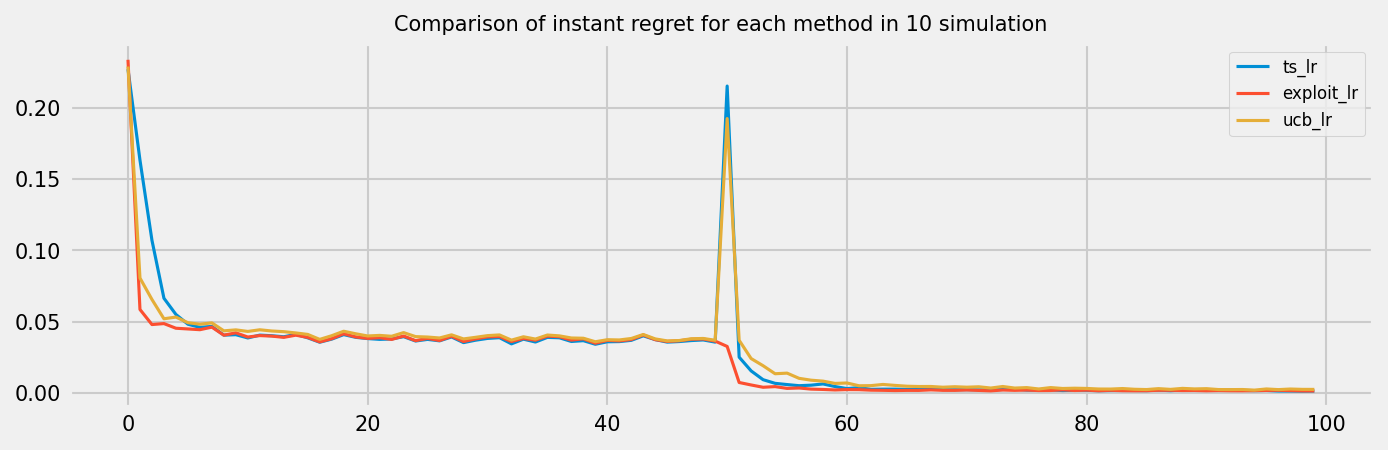

In [25]:
regret_mean = experiment_df.reset_index().groupby(['policy','round'])['regret'].mean()
plot_regret(regret_mean, n_sims, regret_type='cumulative')
plot_regret(regret_mean, n_sims, regret_type='instant')

In [26]:
# plot the learnt weights vs true weight
policies = list(dp_dict.keys())
def get_weights(experiment_df):
    last_round = experiment_df['round'].max()

    experiment_df_last_round = experiment_df[(experiment_df['round'] == last_round - 1) & (experiment_df['simul_id'] == n_sims - 1)]
    weights_df = experiment_df_last_round.groupby(['policy']).agg({'reward': 'sum', 
                                                   'regret': ['count','sum'],
                                                   'true_weights':'first',
                                                   'sample_weights':'first',
                                                   'mean_weights':'first',
                                                   'std_weights':'first'})
    return weights_df

def plot_weight_distribution(weights_df):
    # plot the mean and std of the weights
    plt.close('all')
    plt.figure(figsize=(10, 3), dpi=150)
    # get the final true weights
    true_weights = weights_df.iloc[-1]['true_weights']['first']
    # policies = weights_df.index.values
    for i in range(len(true_weights)):
        plt.figure(figsize=(10, 3), dpi=150)
        m = true_weights[i]
        sigma = 5
        # loop for each decision policy
        for policy in policies:
            X_pdf = np.linspace(m - sigma, m + sigma, 1000)
            online_lr = weights_df.loc[policy]
            pdf = norm_dist(loc=online_lr['mean_weights']['first'][i], scale=online_lr['std_weights']['first'][i]**(-1.0)).pdf(X_pdf)
            plt.plot(X_pdf, pdf, label=policy, linewidth=1.5)

        # plot a vertical line at the true weights
        plt.axvline(x=m, color='black', linestyle='--', label='True weights', linewidth=1.5)
        plt.xlabel('Weights')
        plt.ylabel('Density') 
        plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)   
    plt.show()

<Figure size 1500x450 with 0 Axes>

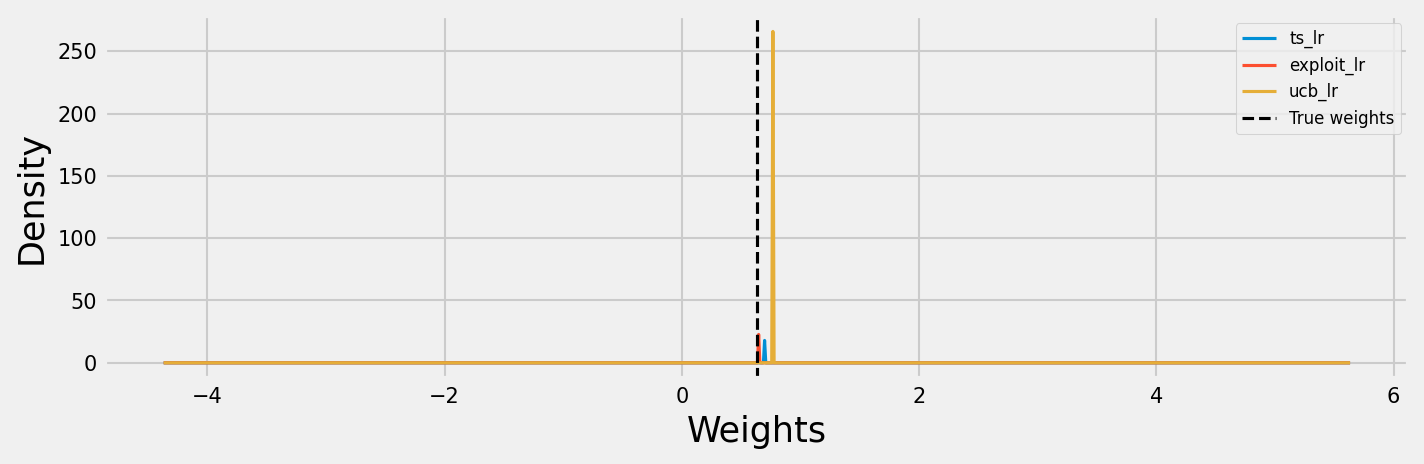

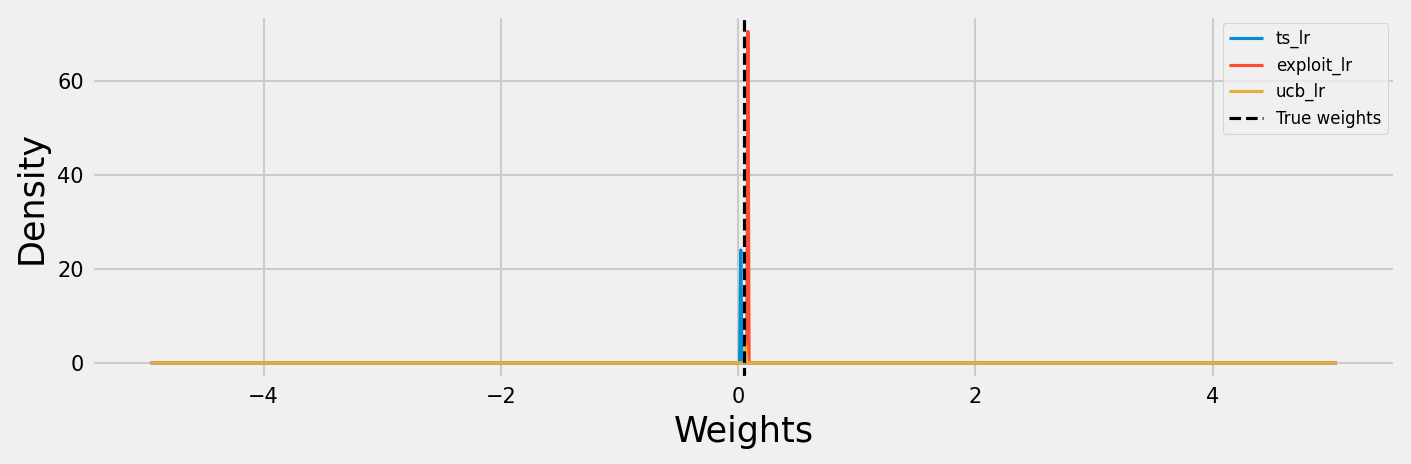

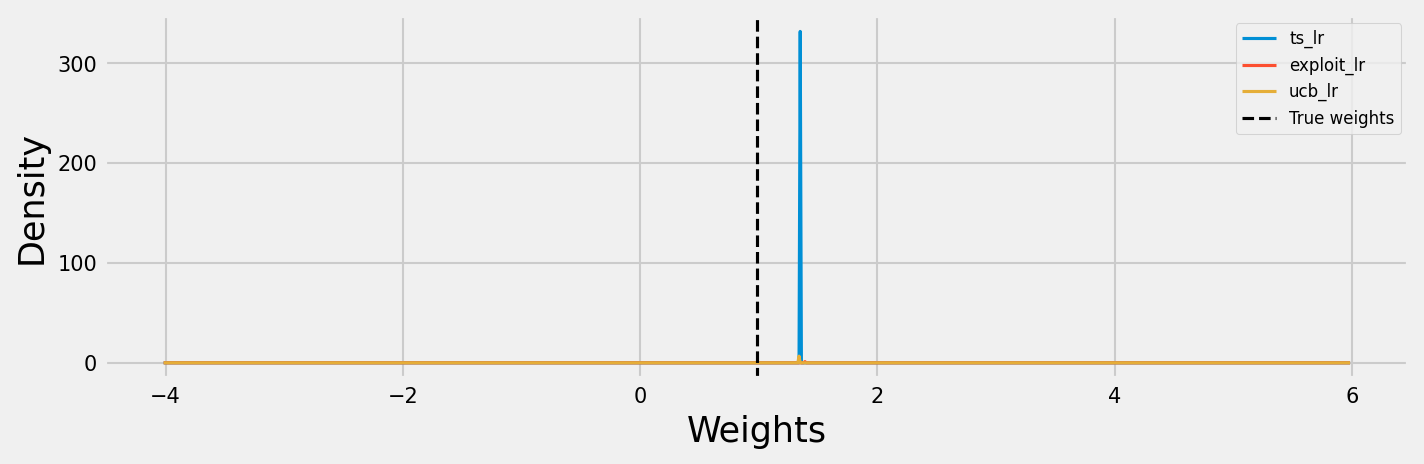

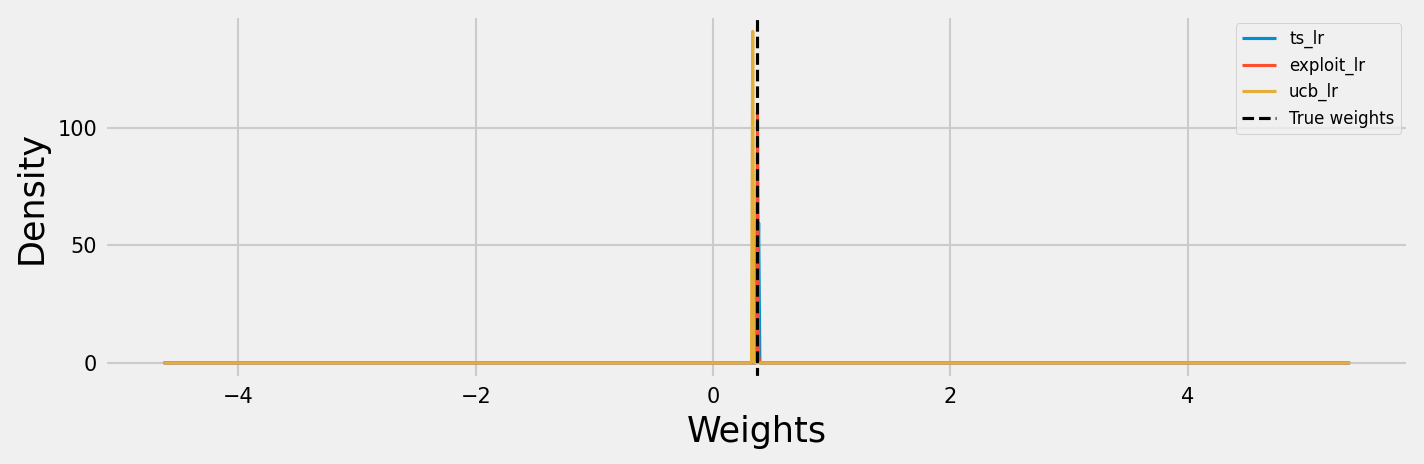

In [27]:
weights_df = get_weights(experiment_df)
plot_weight_distribution(weights_df)

# Plot ALL the configuration results

Analyzing simulation with 10 arms, 100 data points per round, 50 rounds, 3 features, lambda 0.1, alpha 10, 10 simulations


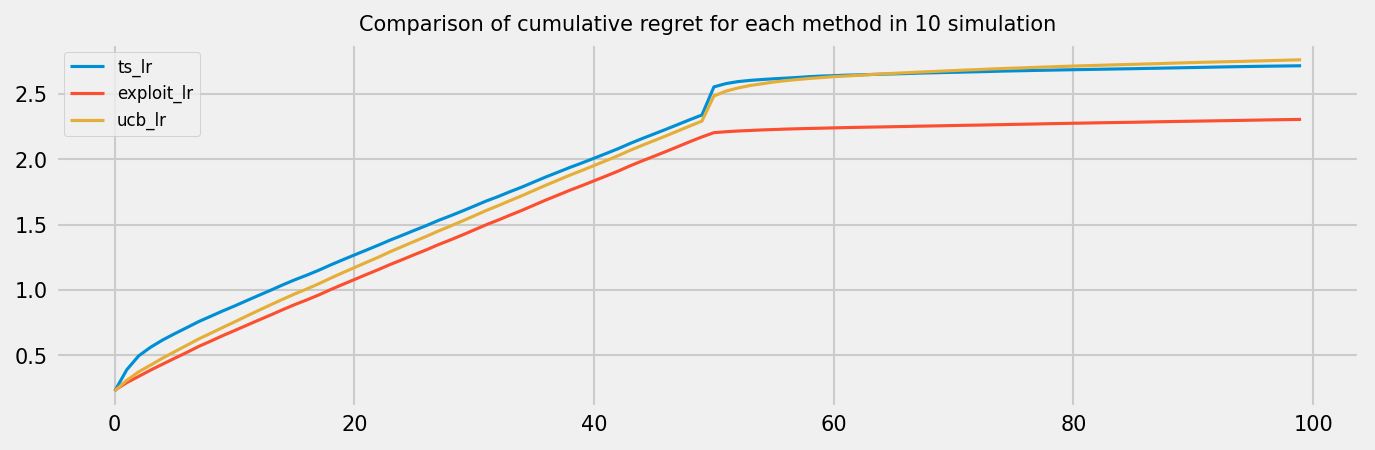

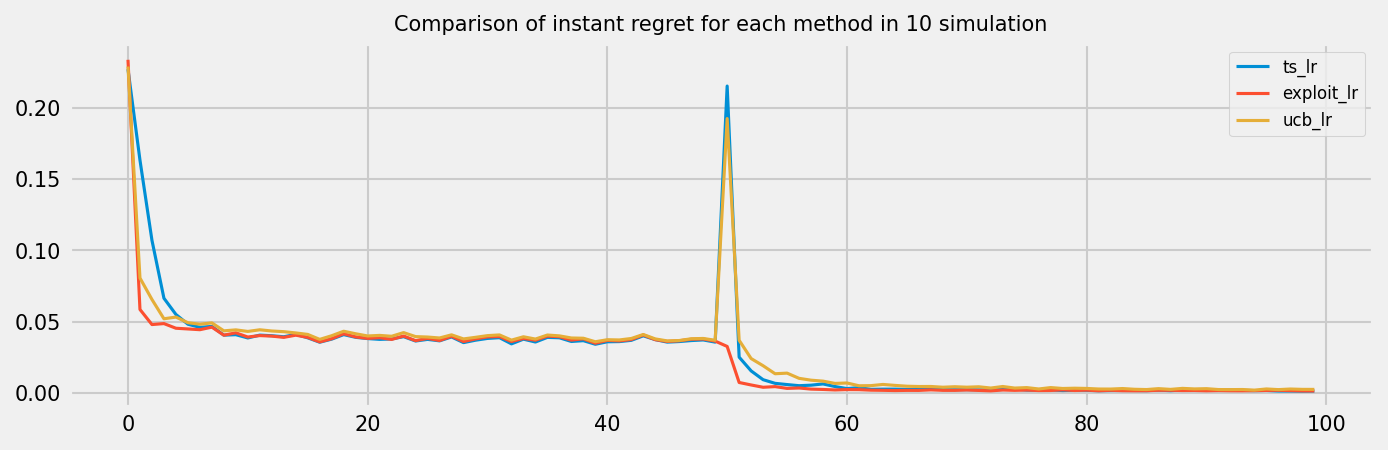

<Figure size 1500x450 with 0 Axes>

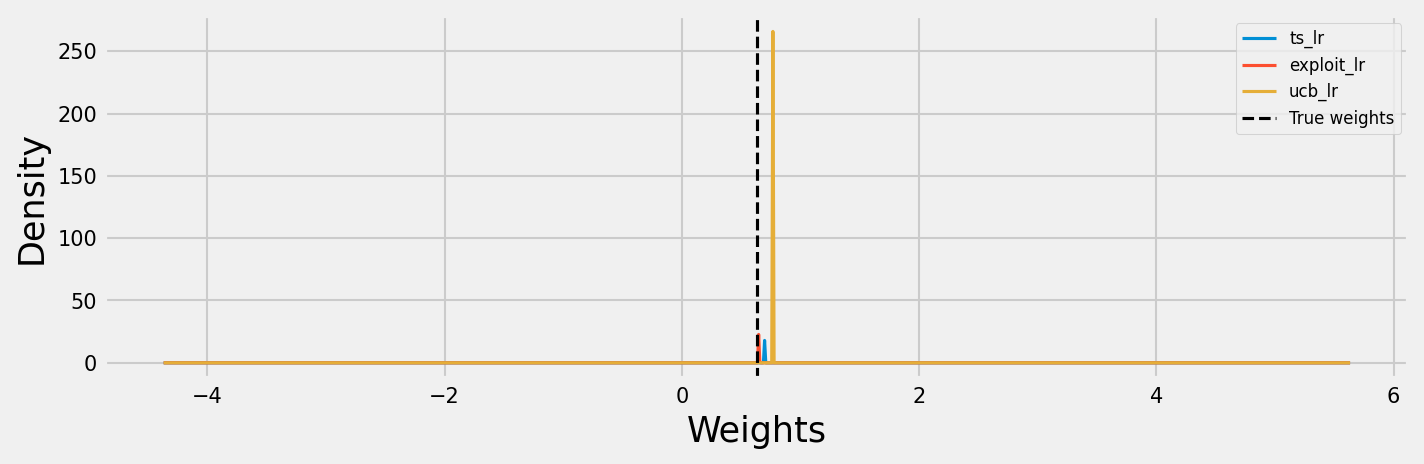

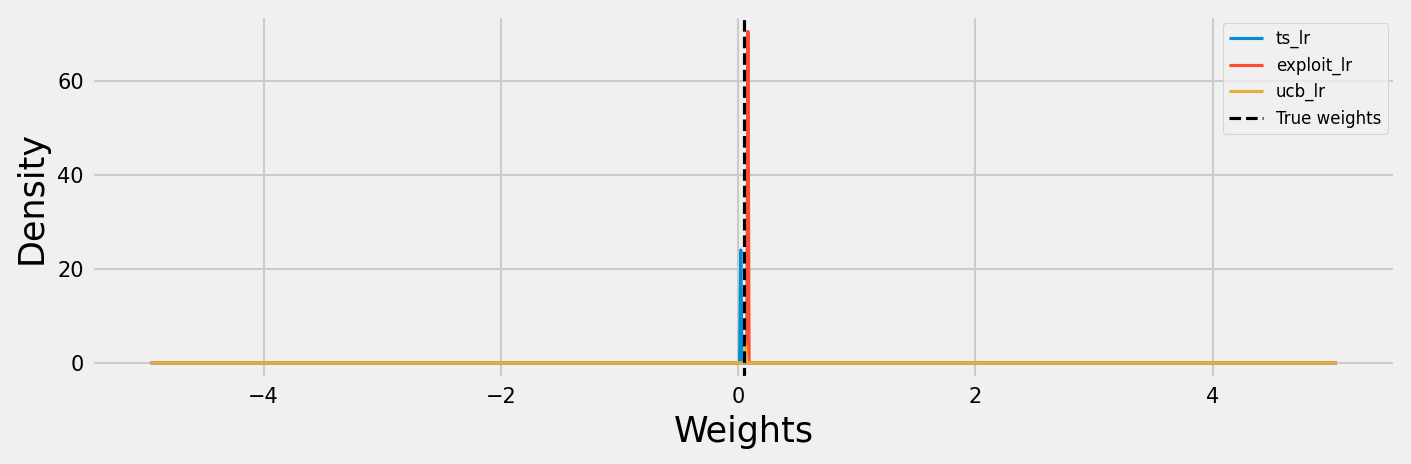

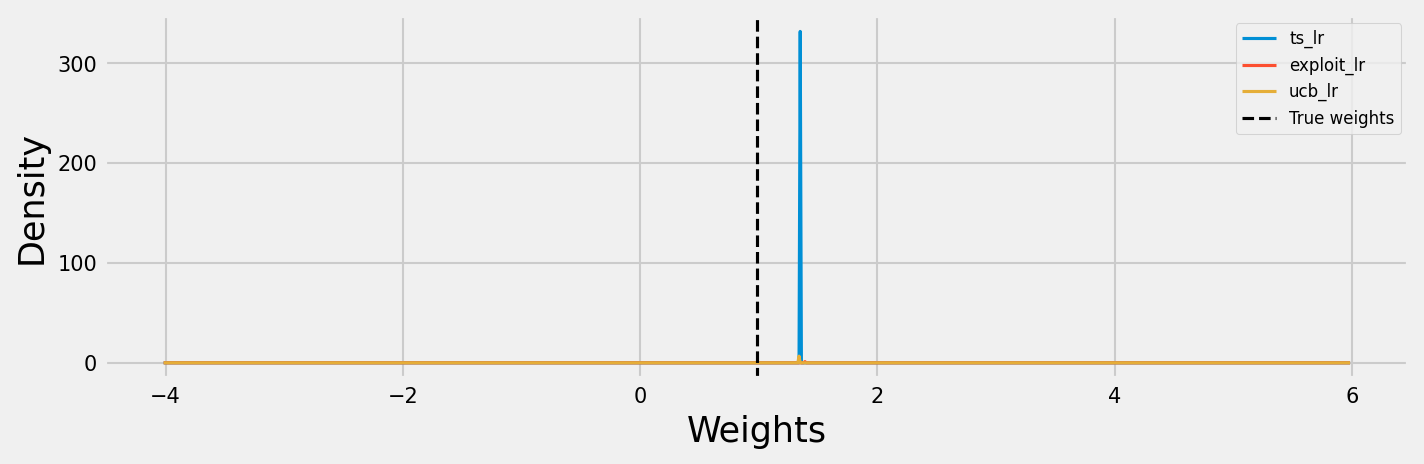

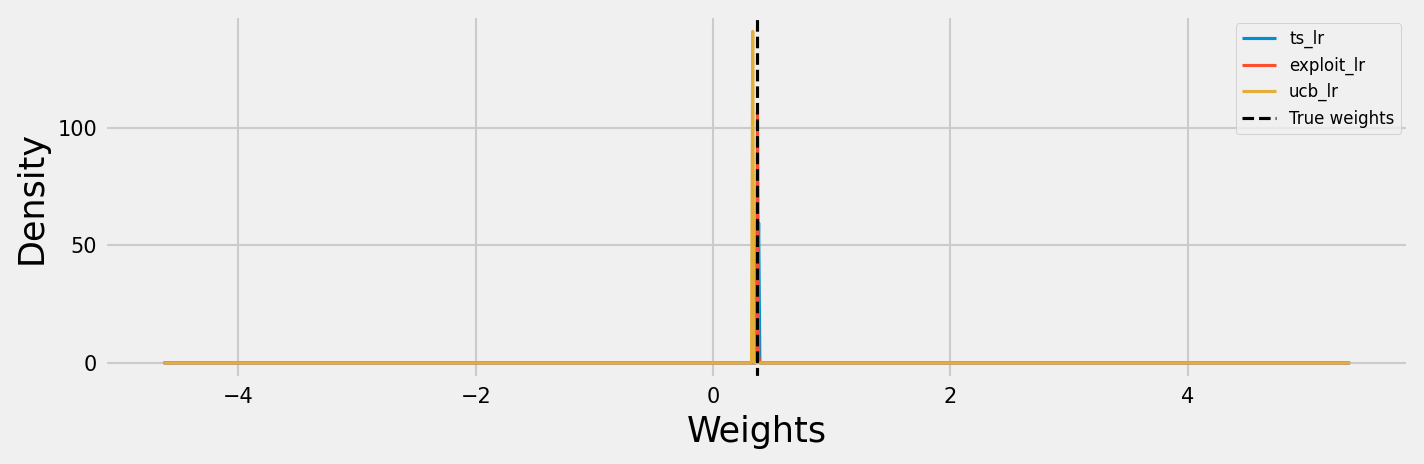

Analyzing simulation with 10 arms, 100 data points per round, 50 rounds, 3 features, lambda 0.1, alpha 10, 10 simulations


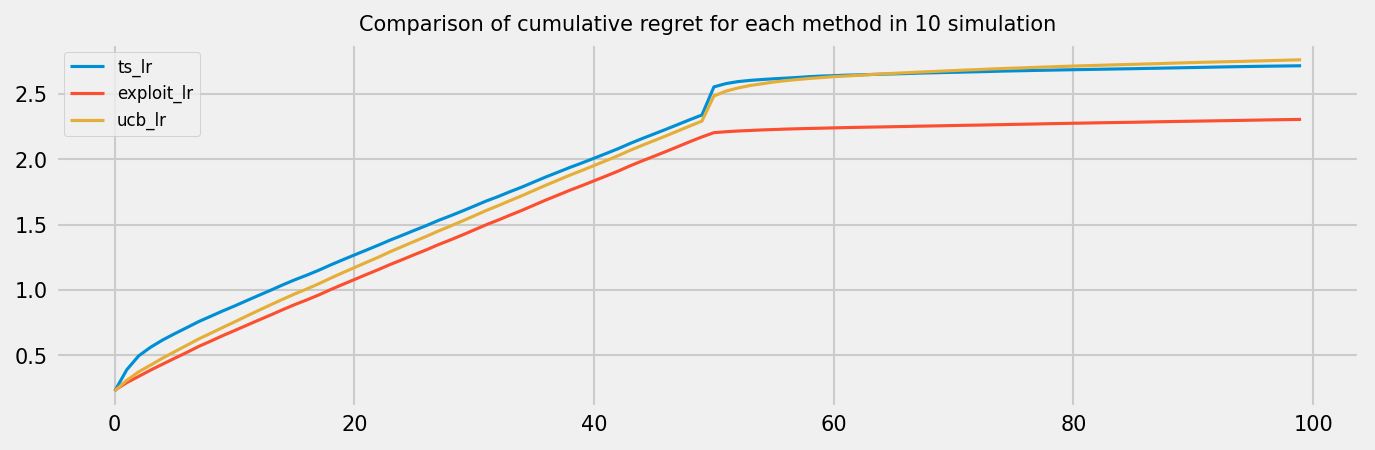

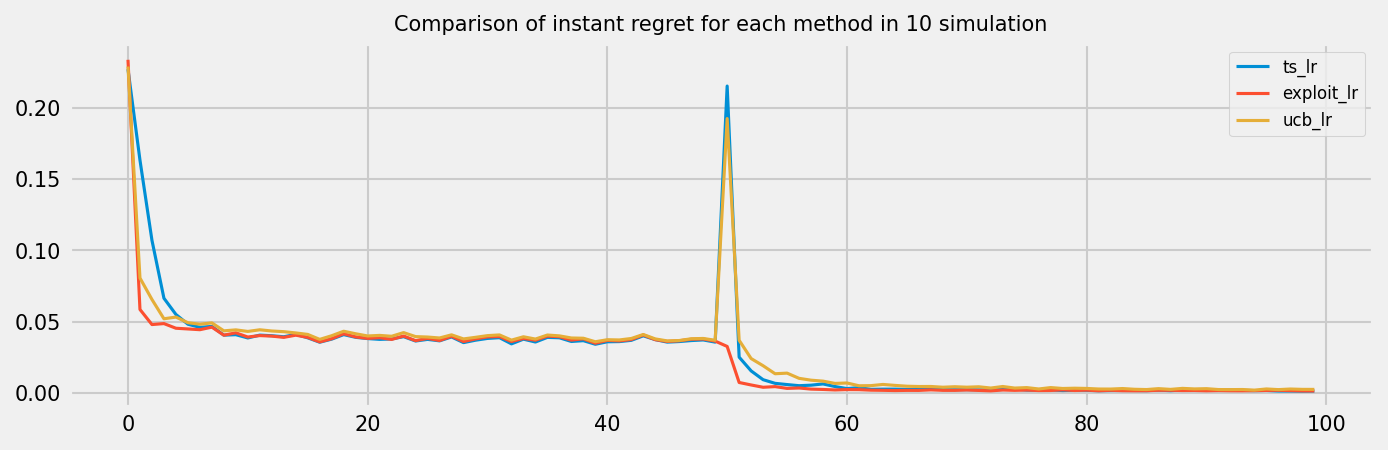

<Figure size 1500x450 with 0 Axes>

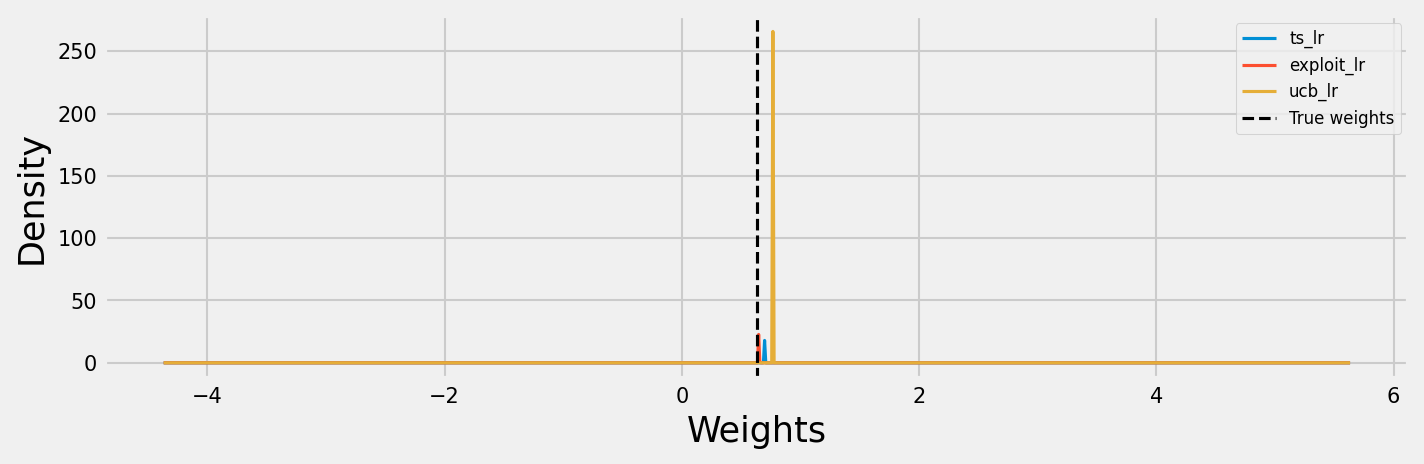

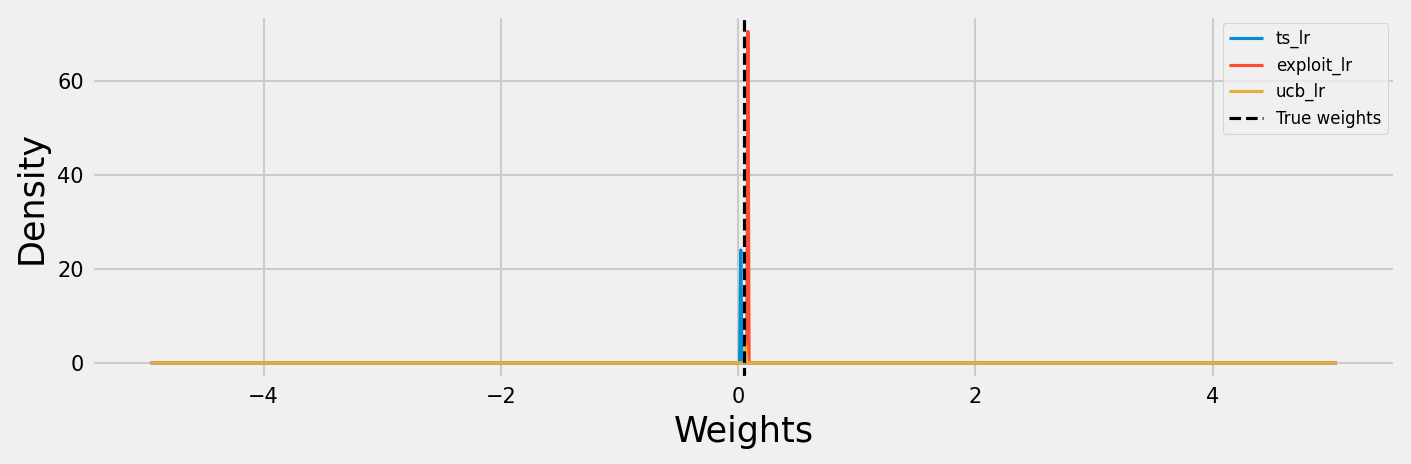

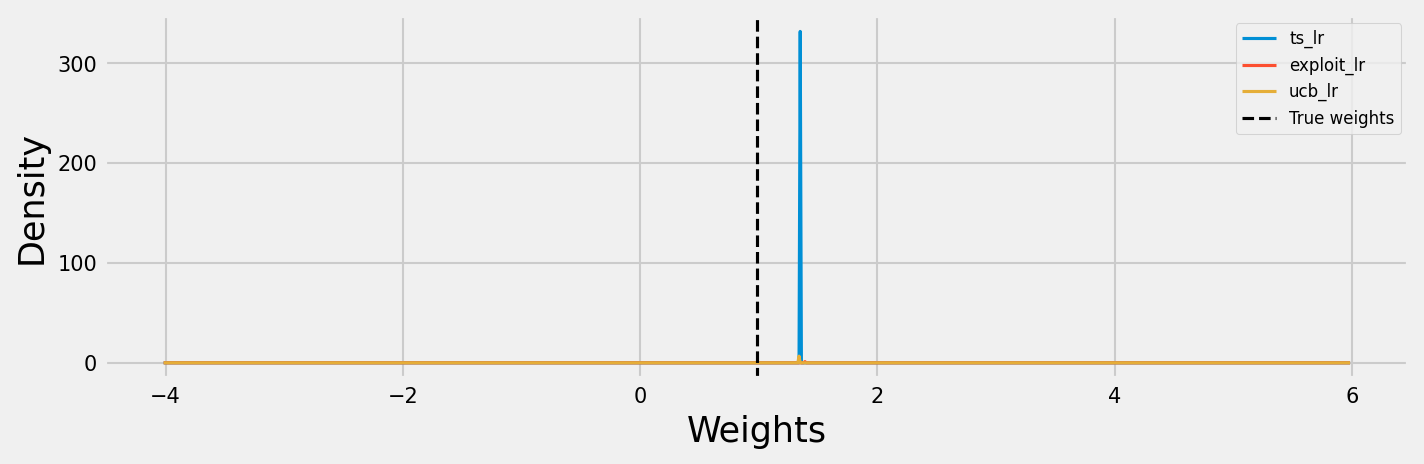

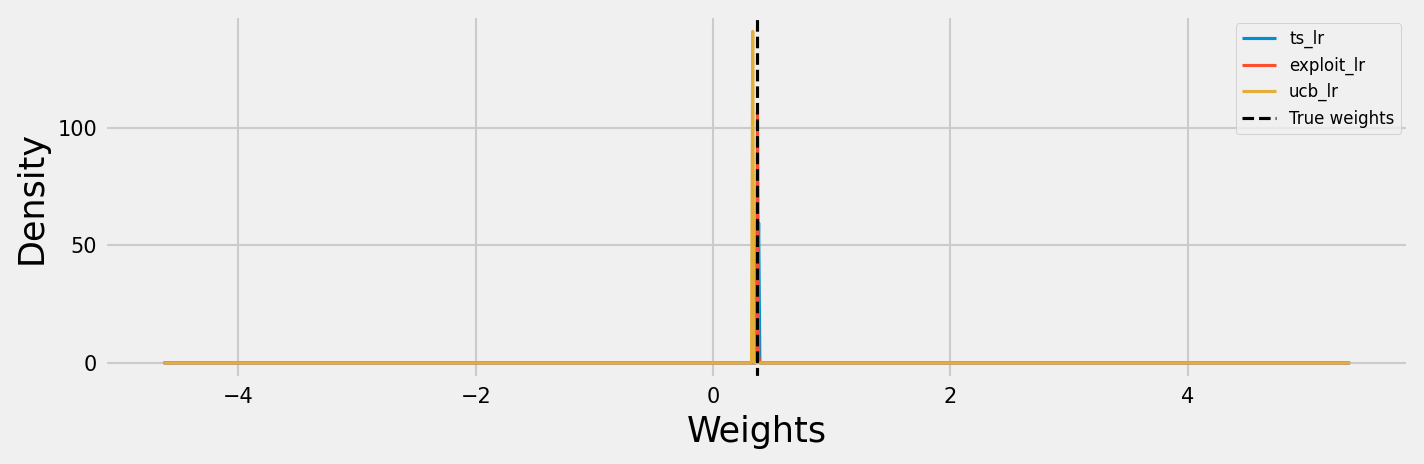

Analyzing simulation with 2 arms, 100 data points per round, 50 rounds, 2 features, lambda 0.1, alpha 10, 10 simulations


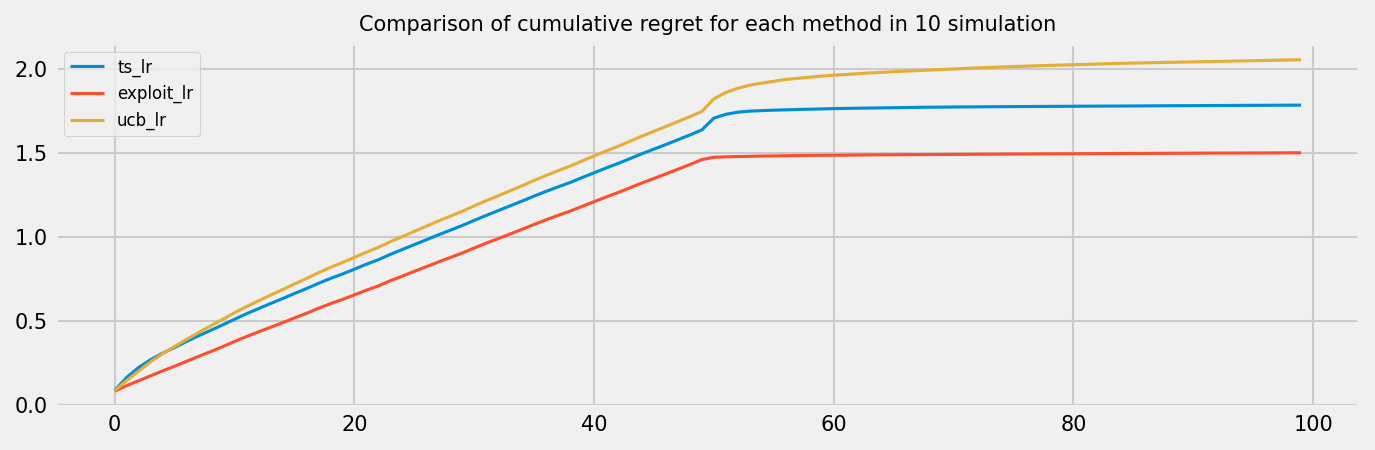

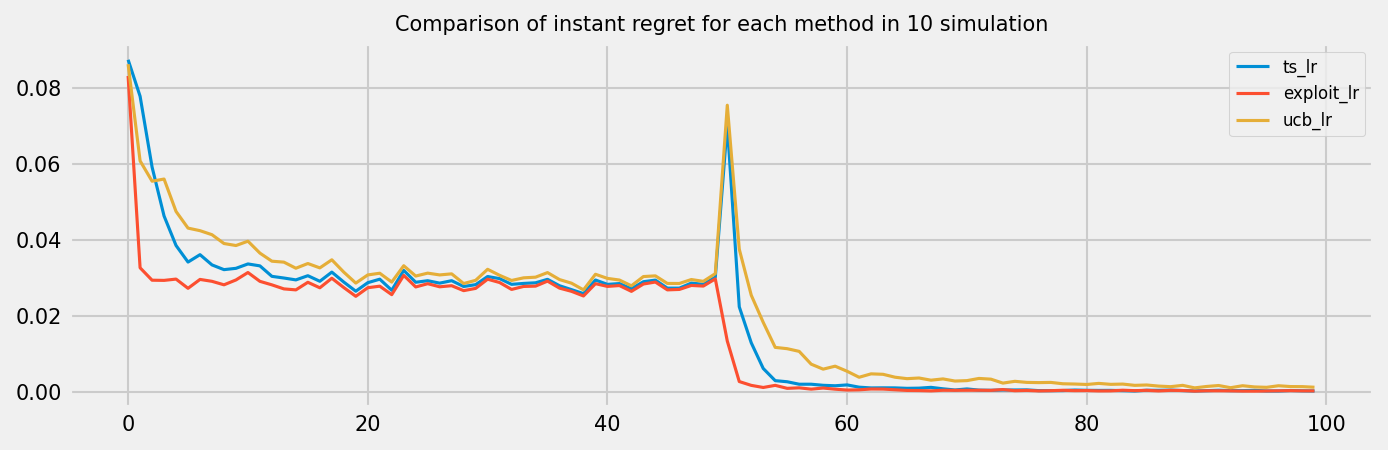

<Figure size 1500x450 with 0 Axes>

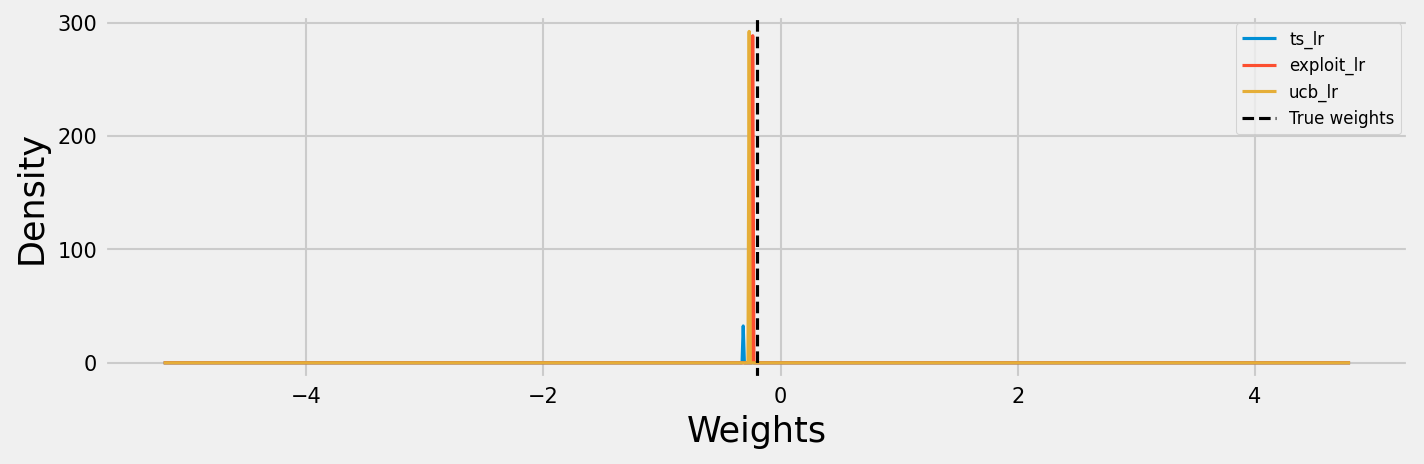

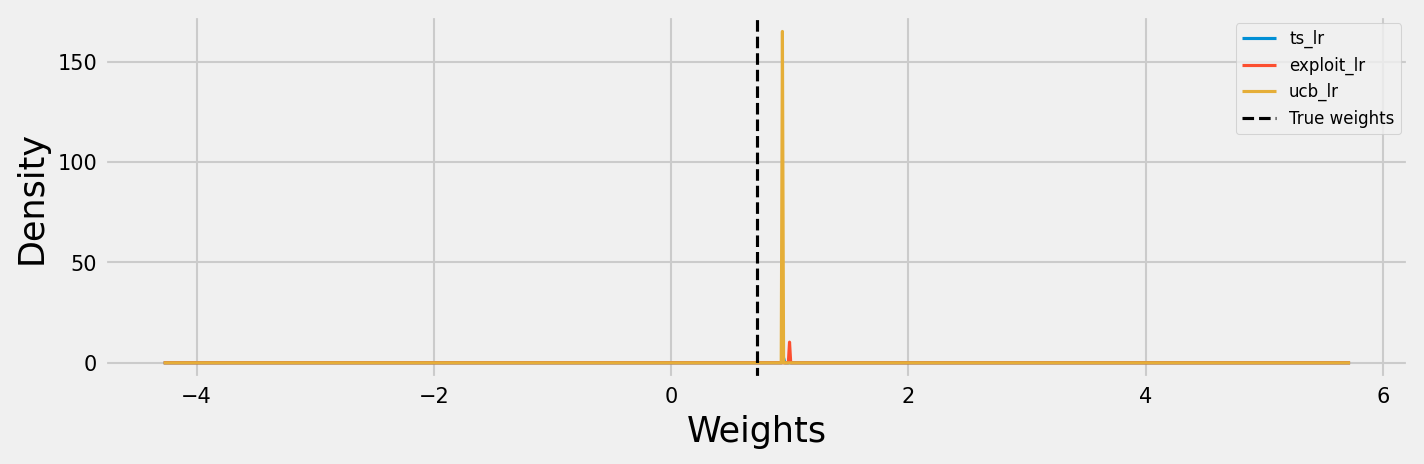

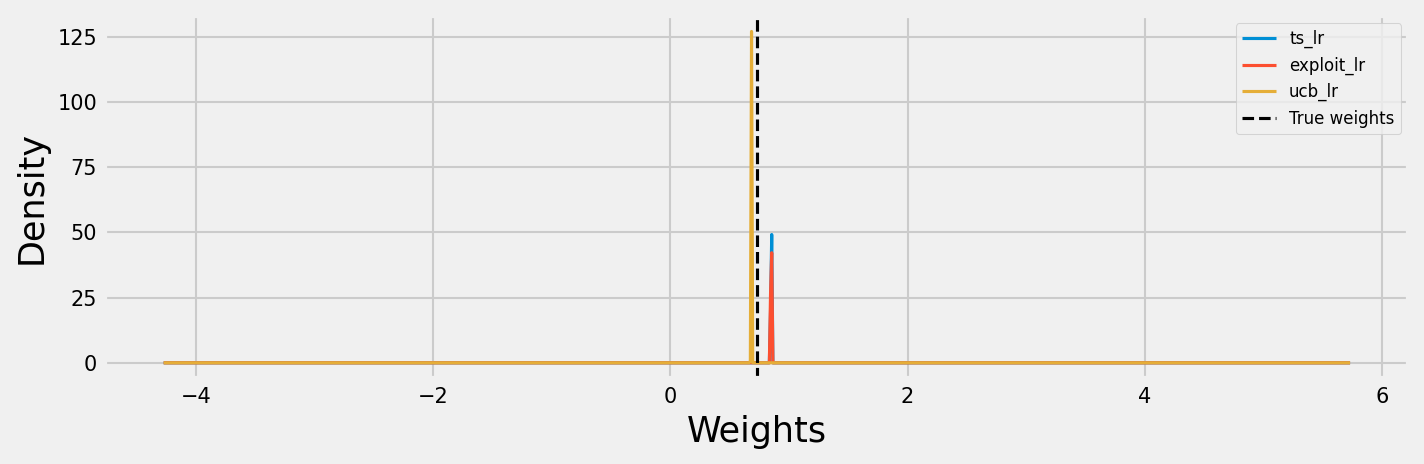

Analyzing simulation with 2 arms, 100 data points per round, 50 rounds, 2 features, lambda 0.1, alpha 10, 10 simulations


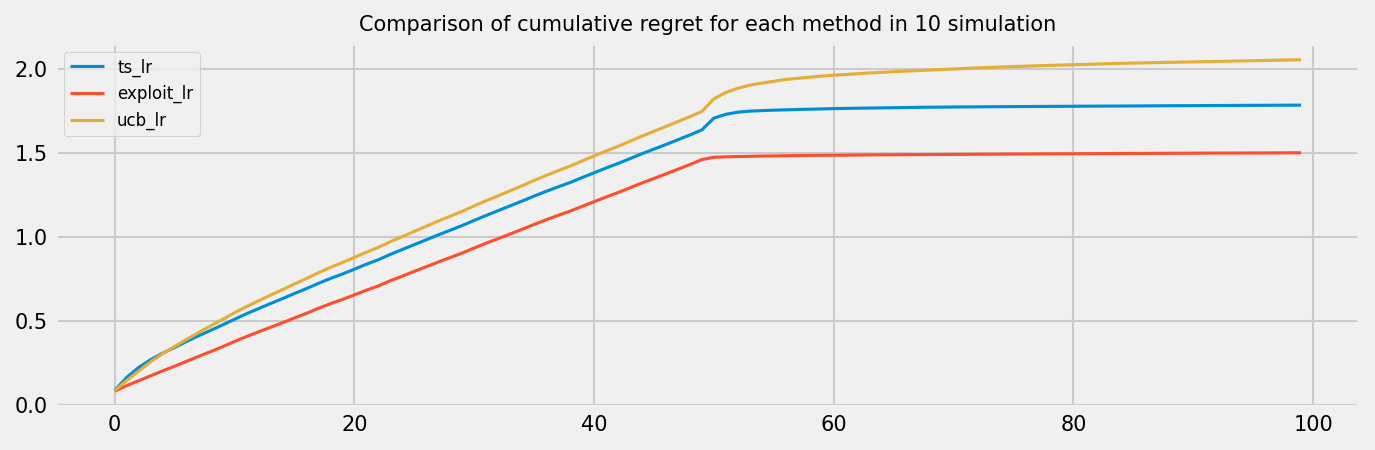

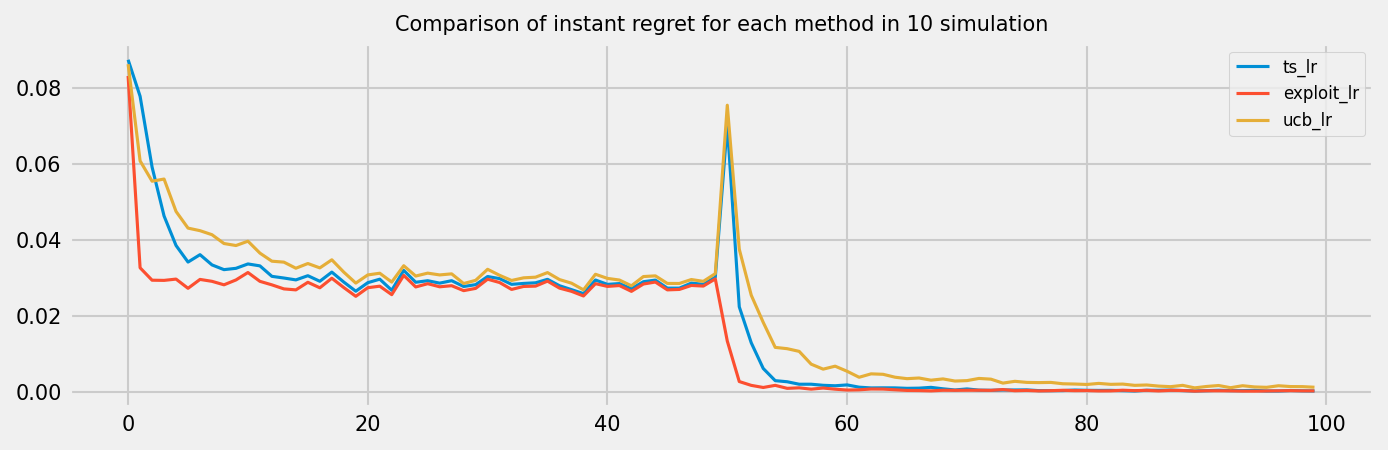

<Figure size 1500x450 with 0 Axes>

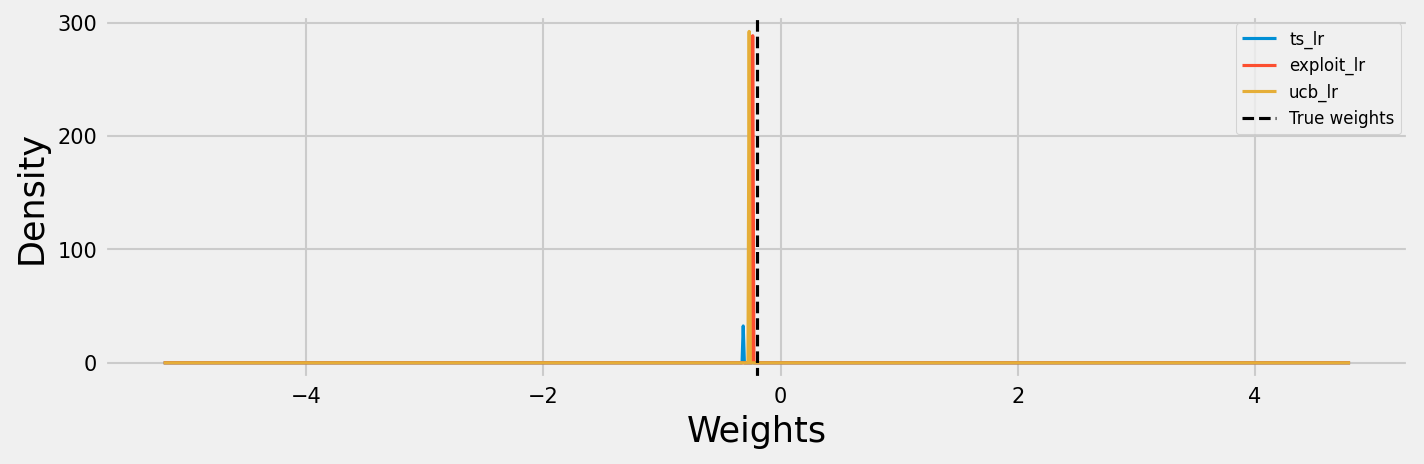

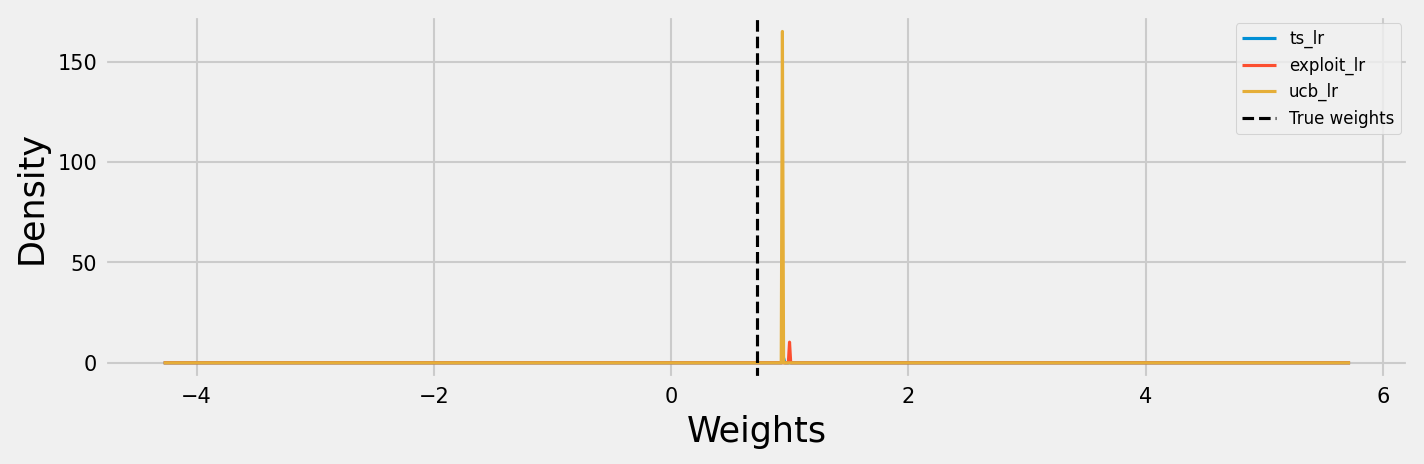

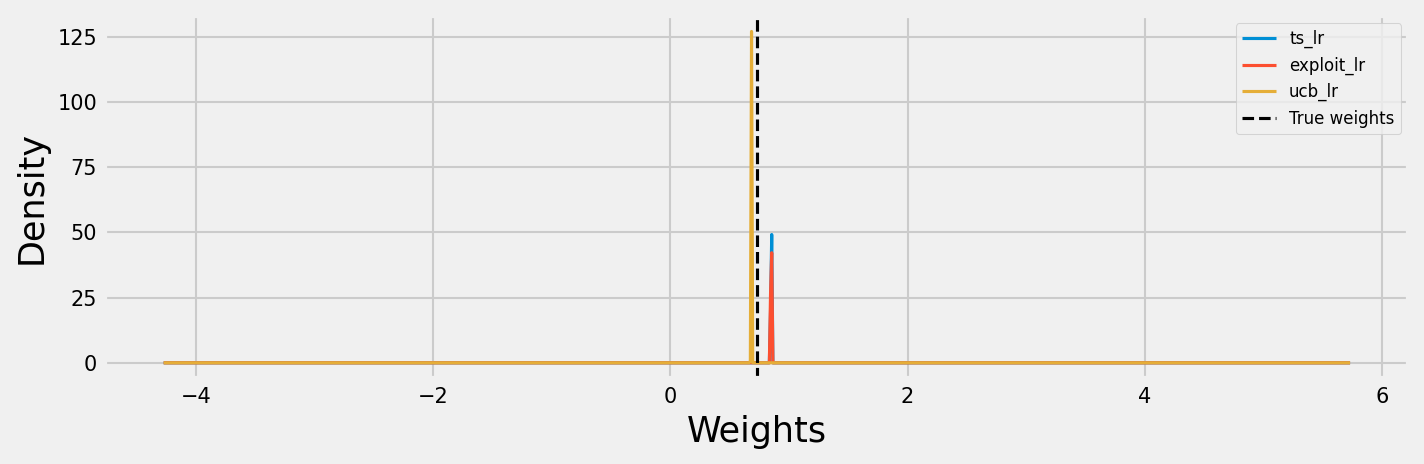

In [28]:
# load the results from pickle
for i in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[i]
    print(f"Analyzing simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    try:
        experiment_df = pd.read_pickle(f"../{result_folder}/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
    except:
        print(f"File not found for {n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}")
        continue
    regret_mean = experiment_df.reset_index().groupby(['policy','round'])['regret'].mean()
    plot_regret(regret_mean, n_sims, regret_type='cumulative')
    plot_regret(regret_mean, n_sims, regret_type='instant')

    #plot weights
    weights_df = get_weights(experiment_df)
    plot_weight_distribution(weights_df)



Interactive namespace is empty.
